# Set up workspace

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs 

In [6]:
import cftime
import scipy

In [7]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import quick_map
from load_ensembles import *

# Load data

In [8]:
dir_input='/glade/work/czarakas/coupled_PPE/data/data_for_figures/EOFs/'
eofs=xr.open_dataset(dir_input+'EOFanalysis_calculated_PREC_FROM_ATM_coupled_EOFs.nc')
pcs=xr.open_dataset(dir_input+'EOFanalysis_calculated_PREC_FROM_ATM_coupled_PCs.nc')
var_explained=xr.open_dataset(dir_input+'EOFanalysis_calculated_PREC_FROM_ATM_coupled_varianceFraction.nc')

In [41]:
dir_input='/glade/work/czarakas/coupled_PPE/data/data_for_figures/annual_means/'

pvals=xr.open_dataset(dir_input+'pval_calculated_PREC_FROM_ATM_Annual_mean_coupled.nc')#['pval']
ds_array=xr.open_dataset(dir_input+'calculated_PREC_FROM_ATM_Annual_mean_coupled.nc')
ds_ref=xr.open_dataset(dir_input+'ref_calculated_PREC_FROM_ATM_Annual_mean_coupled.nc')#['calculated_PREC_FROM_ATM']

In [42]:
var_array=ds_array['calculated_PREC_FROM_ATM']
ref_array=ds_ref['calculated_PREC_FROM_ATM']
pval_array=pvals['pval']

In [11]:
from load_gridcell_areas import *

# Make summary figure

/glade/u/home/czarakas/coupled_PPE/code/utils/quick_map.py:82: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


<Figure size 1728x1080 with 0 Axes>

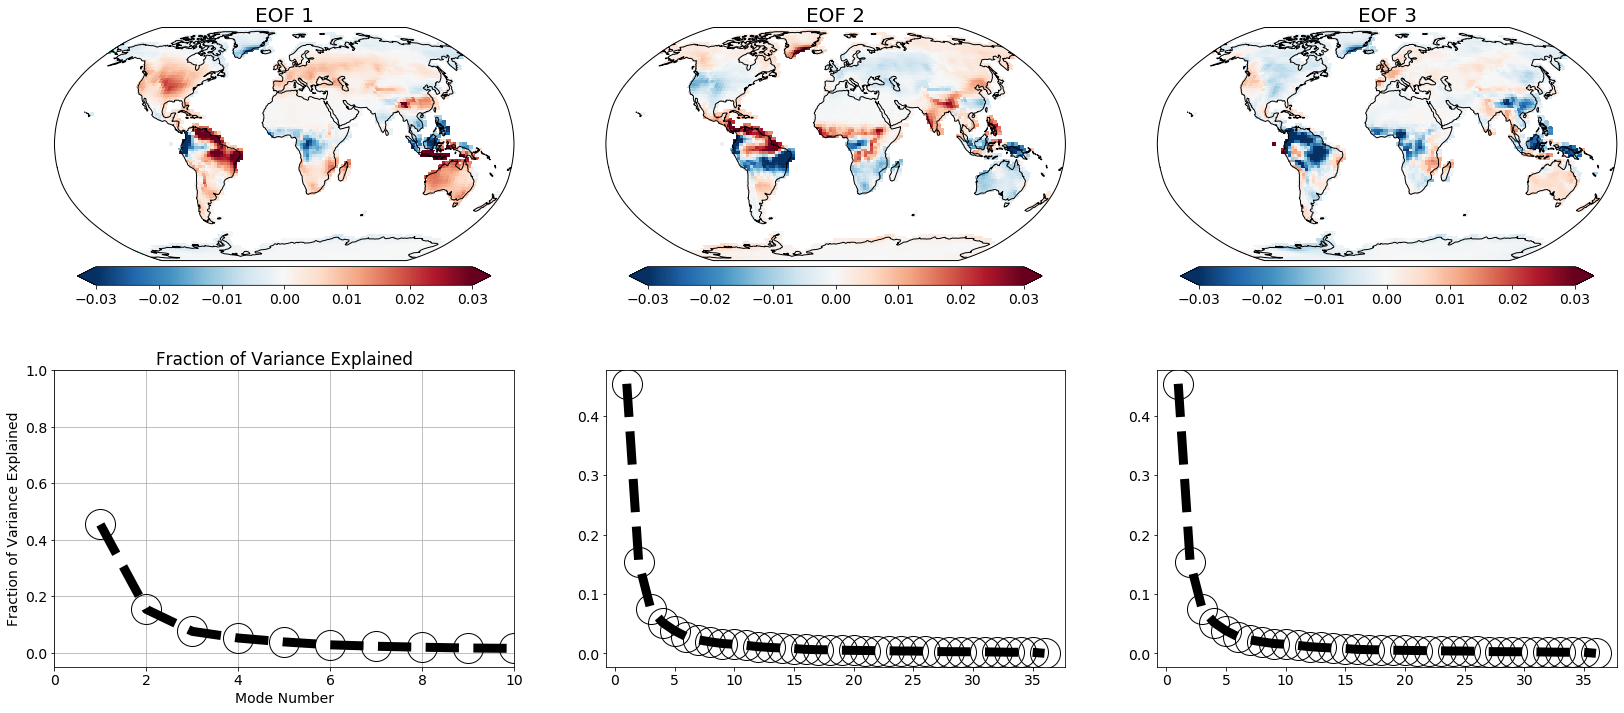

In [12]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(24,15))

lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,3):
    quick_map.quick_map_subplot(((eofs.eofs[:,:,i])/landweights).values,lats,lons, nrow=2, ncol=3, ind=i,
                                clim=[-0.03,0.03], cmap=plt.cm.RdBu_r,
                                title='EOF '+str(i+1))
    
plt.subplot(2,3,4)
plt.plot(var_explained.mode.values+1,var_explained.variance_fractions.values,
         'o--k', fillstyle='none',markersize=30,linewidth=9)#, label=ensemble)
#solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()

plt.subplot(2,3,5)
plt.plot(var_explained.mode.values+1,var_explained.variance_fractions.values,
         'o--k', fillstyle='none',markersize=30,linewidth=9)#, label=ensemble)

plt.subplot(2,3,6)
plt.plot(var_explained.mode.values+1,var_explained.variance_fractions.values,
         'o--k', fillstyle='none',markersize=30,linewidth=9)#, label=ensemble)

In [13]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(var_explained.variance_fractions.values[i])
    print(np.sum(var_explained.variance_fractions.values[:i+1]))
#print(solver.varianceFraction().values[0:2])

EOF 1
0.45397704457825944
0.45397704457825944
EOF 2
0.15331748438848988
0.6072945289667493
EOF 3
0.07538886628254615
0.6826833952492954
EOF 4
0.05187099398933184
0.7345543892386273


In [14]:
warming_factorPC0_1degreeglobal=1/(eofs.eofs[:,:,0]).mean(dim=['lat','lon'])
mapdata=eofs.eofs[:,:,0]*warming_factorPC0_1degreeglobal/landweights


In [15]:
descriptions = []
for key in var_array.ensemble_key.values:
    if np.nansum(crosswalk.Key_short==key)>0:
        descriptions.append(crosswalk.description[crosswalk.Key_short==key].values[0])
    else:
        print('Error')
     #   descriptions.append('0000')
    #print(key)#ensemble_coupled=load_coupled_ensemble(var=var)

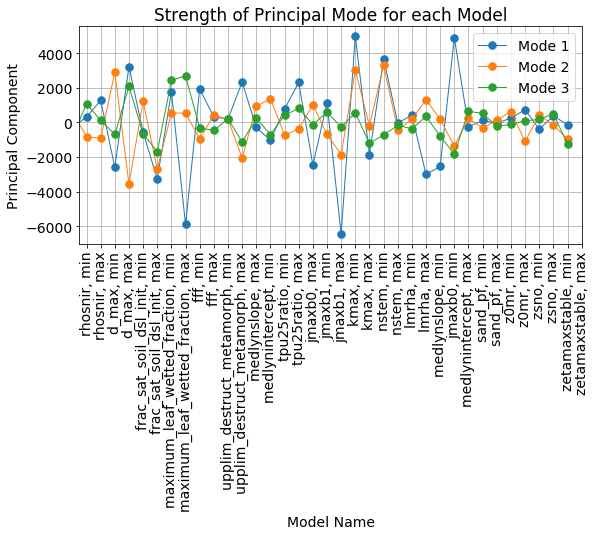

In [16]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
#plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = (pcs.pcs[:,i])
    plt.plot(pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()

In [17]:
mod_factor=np.std(pcs.pcs[:,0])
pcs_mod=pcs.pcs/mod_factor
eofs_mod=eofs.eofs*mod_factor

In [18]:
crosswalk['PREC_mode0']=np.nan
for i, key in enumerate(var_array.ensemble_key.values):
    crosswalk.loc[crosswalk.Key_short==key,['PREC_mode0']]=pcs_mod[:,0].values[i]

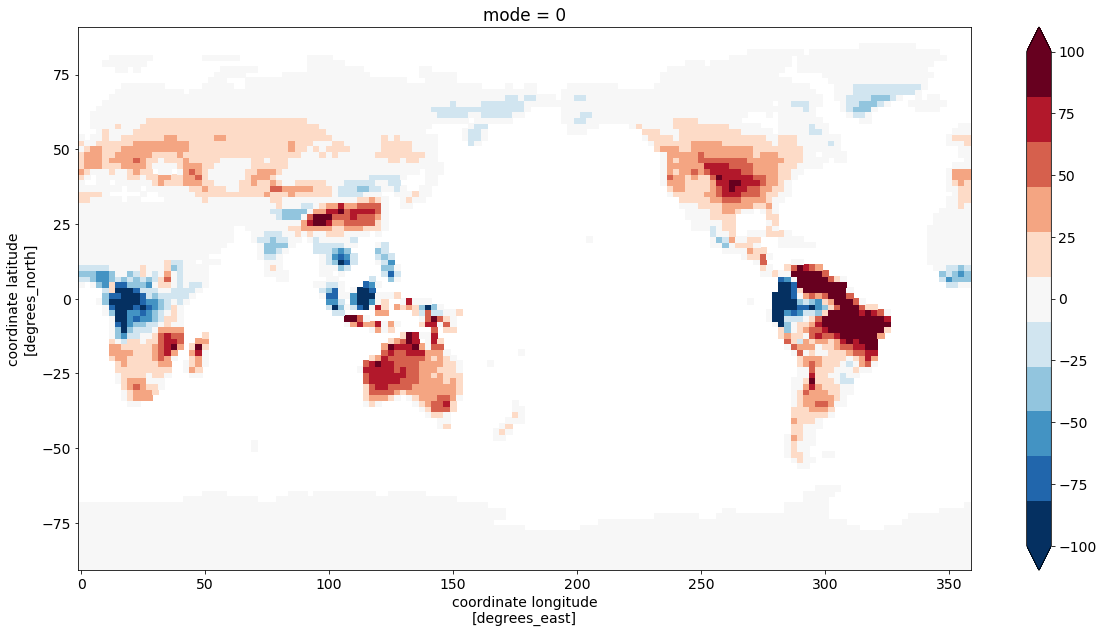

In [19]:
fig = plt.figure(figsize=(20, 10))
eofs_mod[:,:,0].plot(cmap=plt.cm.get_cmap("RdBu_r",11), vmin=-100, vmax=100)

### Absolute change

In [91]:
mapdata=eofs_mod[:,:,0]

In [92]:
(mapdata*landweights).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(11.09721849)
Coordinates:
    mode     int64 0

In [93]:
sigmask=((pval_array>0.05).sum(dim=['ensemble_key'])>=31)

In [78]:
31/36

0.8611111111111112

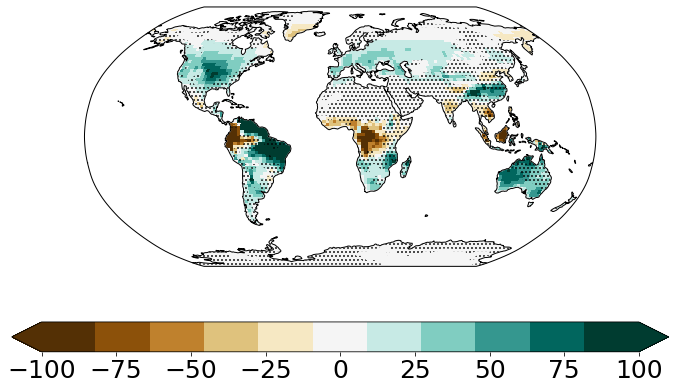

In [96]:
import cartopy
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("BrBG",11), vmin=-100, vmax=100,#levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-0.025, 0.030, 0.005))

cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=sigmask.lon)
ax.contourf(
            cyclic_lons_mask, sigmask.lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['...'])
        
plt.tight_layout()
ax.add_feature(cartopy.feature.OCEAN, facecolor='white', zorder=1)
ax.coastlines()
plt.savefig('Range_pct_change.png')
#plt.savefig('Figures/Range_pct_change.eps')

### Percentage basis

In [34]:
mapdata=eofs_mod[:,:,0]*100/(ref_array*86400*365)

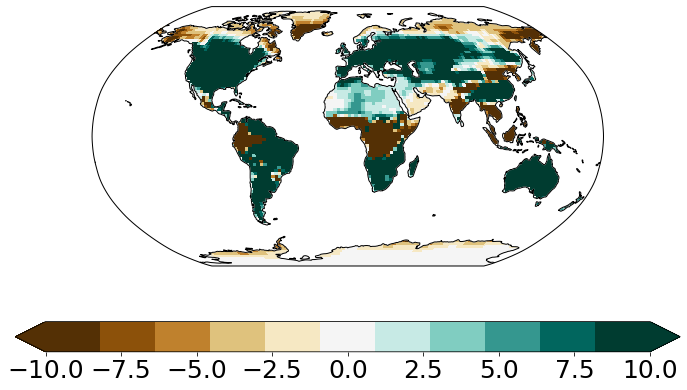

In [90]:
import cartopy
plt.rcParams.update({'font.size': 25})
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   cmap=plt.cm.get_cmap("BrBG",11), vmin=-10, vmax=10,#levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree())#, extend='both')
plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-0.025, 0.030, 0.005))

#cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=sigmask.lon)
#ax.contourf(
#            cyclic_lons_mask, sigmask.lat, cyclic_data_mask,
#            transform=ccrs.PlateCarree(),
#            colors='none',
#            levels=[0.5, 1.5],
#            hatches=['...'])
        
plt.tight_layout()
ax.add_feature(cartopy.feature.OCEAN, facecolor='white', zorder=1)
ax.coastlines()
plt.savefig('Range_pct_change.png')
#plt.savefig('Figures/Range_pct_change.eps')

In [83]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 
        'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'maximum_leaf_wetted_fraction',
        'rhosnir',
        'lmrha',
        'nstem',
        ]
param_colors=['skyblue','skyblue', 'skyblue','skyblue',
        '#F8CBAD', 
              'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              '#6CD2E9',
              'goldenrod',
              'lightgreen',
        'orange',
              ]

In [84]:
legend_categories=['Soil hydrology',
        'Snow', 
        'Roughness / boundary layer',
        'Plant water use',
        'Photosynthesis',
                   'Canopy evaporation',
        'Plant radiative properties',
        'Temperature acclimation',
        'Biomass heat storage',
        ]
category_colors=['skyblue',
        '#F8CBAD', 
              'purple', 
        'forestgreen', 
        'lightseagreen', 
               '#6CD2E9',
              'goldenrod',
              'lightgreen',
        'orange',
              ]

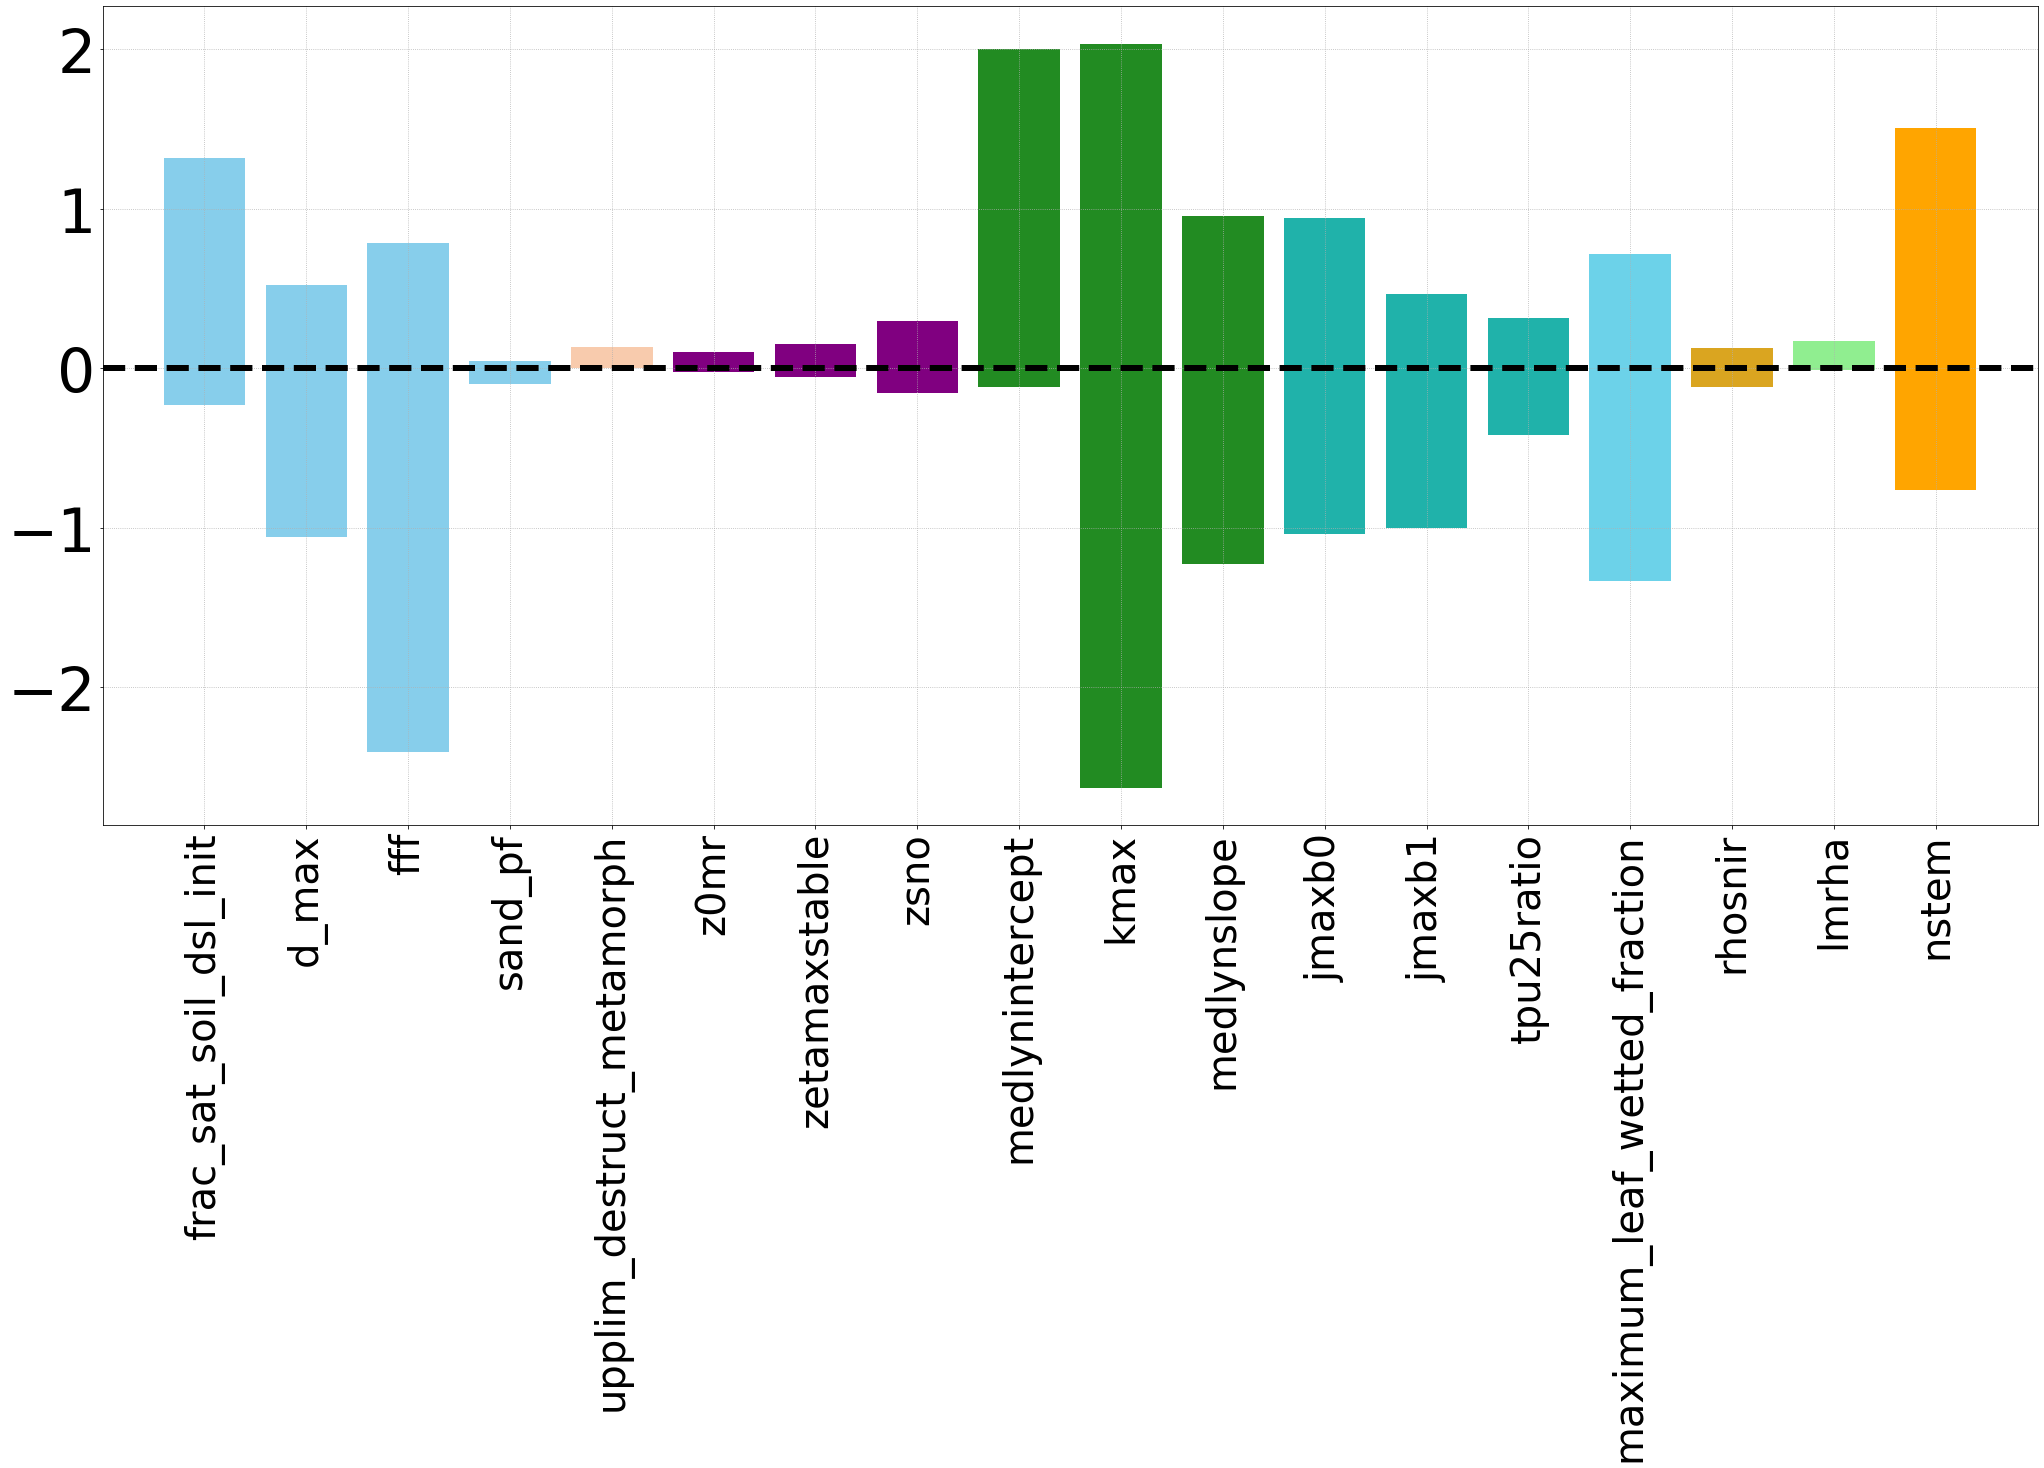

In [85]:
plt.rcParams.update({'font.size': 60})
plt.figure(figsize=(30,22))
lwidth=6
plt.axhline(y=0,linestyle='--',color='k', linewidth=lwidth)

for i, param in enumerate(params):
    minval=crosswalk['PREC_mode0'].values[crosswalk.description==param+', min']
    maxval=crosswalk['PREC_mode0'].values[crosswalk.description==param+', max']
    plt.bar(i,minval, color=param_colors[i])
    plt.bar(i,maxval, color=param_colors[i])
    
    #minval_PC0=crosswalk['PC0'].values[crosswalk.description==param+', min']
    #maxval_PC0=crosswalk['PC0'].values[crosswalk.description==param+', max']
    #plt.plot([i,i], 
    #         [minval_PC0,maxval_PC0],'x', markersize=20,linewidth=8, color='k')
    
    

xticks=plt.xticks(np.arange(0, i+1), params, rotation='vertical',fontsize=40)
plt.grid(linestyle=':')
plt.xlim([-1,np.size(params)])
plt.tight_layout()
plt.savefig('Figure1b.eps')